In [1]:
import requests

from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Web-scraping with BeautifulSoup and import to Pandas

In [2]:
walkscore_url = "https://www.walkscore.com/CA/San_Francisco"

response = requests.get(walkscore_url)
page = response.text
soup = BeautifulSoup(page, "lxml")

soup.find('td').findNextSibling()

<td class="name"><a href="/CA/San_Francisco/Chinatown">Chinatown</a></td>

In [3]:
tables = soup.find_all("table")

names = {}
rows = [row for row in tables[0].find_all('tr')]

for row in rows[1:]:
    items = row.find_all('td')
    name = items[1].find('a').text
    names[name] = [i.text for i in items[1:]]

    
list(names.items())[0] # It worked!

('Chinatown', ['Chinatown', '100', ' 100 ', ' 67 ', '8,646'])

In [4]:
index=['name', 'walk_score', 'transit_score', 'bike_score', 'population']
df_web_scraped = pd.DataFrame(data=names, index=index)
df_web_scraped = df_web_scraped.transpose()
df_web_scraped = df_web_scraped.reset_index()

If BeautifulSoup above doesn't work, use Pandas as a back-up, but the formatting cell below will need to be re-tooled to accommodate the slightly different table format that comes in via Pandas.

In [5]:
# tables = pd.read_html(walkscore_url)
# df_clean = tables[0]

### DataFrame Formatting:
I'm dropping the other columns that Walk Score has generated for the neighborhoods (`transit_score` and `bike_score`) because keeping them in would give my model an unfair head-start; the scores are too similar in nature and that would defeat the purpose of my project.

In [6]:
df_clean = df_web_scraped.drop(columns=['index', 'transit_score', 'bike_score'])
df_clean.columns = ['name', 'walk_score', 'population']

df_clean['population'] = df_clean['population'].str.replace(',', '')

df_clean['walk_score'] = df_clean['walk_score'].astype(float)
df_clean['population'] = df_clean['population'].astype(float)

df_clean.info() # Now we have floats!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
name          110 non-null object
walk_score    110 non-null float64
population    110 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.7+ KB


# Importing data to GeoPandas:

The following GeoJSON file is from https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

In [7]:
gdf = gpd.read_file('data/sf-find-neighborhoods.geojson')

# Consolidating name duplicates, such as: 
# 'Aquatic Park / Ft. Mason' vs 'Aquatic Park-Fort Mason'
# 'Candlestick Point SRA' vs 'Candlestick Point State Recreation Area'
# Etc. 

for i, row in enumerate(gdf['name']):
    if '/ Ft.' in row:
        gdf['name'][i] = row.replace(" / Ft.", "-Fort")
    elif '/' in row:
        gdf['name'][i] = row.replace(" / ", "-") #.copy()
    elif 'Mission' == row:
        gdf['name'][i] = row.replace("Mission", "Mission District")
    elif 'Marina' == row:
        gdf['name'][i] = row.replace("Marina", "Marina District")
    elif 'SRA' in row:
        gdf['name'][i] = row.replace("SRA", "State Recreation Area") #.copy()

# sorted(gdf['name'].unique())

In [8]:
# Don't need the 'link' column:
gdf = gdf.drop(columns=['link'])

### Merging Walk Score DataFrame with the GeoDataFrame:

In [9]:
gdf2 = gdf.merge(df_clean, how='outer', on=['name'])

Converting area from units of "square-degrees of latitude and longitude" to acres. 

In San Francisco, one degree of longitude is 289,333 feet and one degree of latitude is 364,131 feet. One acre is 43,560 square feet.

In [10]:
sq_ft_per_lat_lon = 289_333 * 364_131 # (That's a lot of square feet!)
sq_ft_per_acre = 43_560 

acres_per_lat_lon = sq_ft_per_lat_lon / sq_ft_per_acre

I'll use neighborhood centroids as a representative point for the step when I look up `walk_score` and `population` for the neighborhoods that the Walk Score website omits.

In [11]:
gdf2['centroid'] = gdf2['geometry'].centroid
gdf2['hood_area'] = gdf2['geometry'].area * acres_per_lat_lon # Now all areas are in acres

There are 7 `walk_score` and `population` NaNs. Walk Score has omitted these neighborhoods from the table that I scraped from their website, so I used the neighborhood centroid to look up a representative Walk Score for that neighborhood. I also made reasonable attempts to find population for these omitted neighborhoods.

In [12]:
# The operations for these rows are commented out, as they get lost later in the merges.

gdf2.loc[6,  'walk_score'] = 23 # 'Lincoln Park-Fort Miley' is being assigned walk_score = 23
gdf2.loc[8,  'walk_score'] = 66 # 'Golden Gate Park' is being assigned walk_score = 66
gdf2.loc[34, 'walk_score'] = 3  # 'Yerba Buena Island' is being assigned walk_score = 3
gdf2.loc[55, 'walk_score'] = 41 # 'Central Waterfront' is being assigned walk_score = 41
gdf2.loc[75, 'walk_score'] = 62 # 'India Basin' is being assigned walk_score = 62
gdf2.loc[81, 'walk_score'] = 81 # 'Apparel City' is being assigned walk_score = 81
gdf2.loc[84, 'walk_score'] = 80 # 'Produce Market' is being assigned walk_score = 80

gdf2.loc[6,  'population'] = 0    # 'Lincoln Park-Fort Miley' population
gdf2.loc[8,  'population'] = 0    # 'Golden Gate Park' population
gdf2.loc[34, 'population'] = 471  # 'Yerba Buena Island' population
gdf2.loc[55, 'population'] = 2603 # 'Central Waterfront' population
gdf2.loc[75, 'population'] = 2722 # 'India Basin' population
gdf2.loc[81, 'population'] = 816  # 'Apparel City' population
gdf2.loc[84, 'population'] = 1317 # 'Produce Market' population

gdf2.query("name == 'Golden Gate Park'") # Yep, it worked!
gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 117 entries, 0 to 116
Data columns (total 6 columns):
name          117 non-null object
geometry      117 non-null object
walk_score    117 non-null float64
population    117 non-null float64
centroid      117 non-null object
hood_area     117 non-null float64
dtypes: float64(3), object(3)
memory usage: 11.4+ KB


In [13]:
# Don't need the centroid column any more, dropping it:
gdf2 = gdf2.drop(columns=['centroid'])

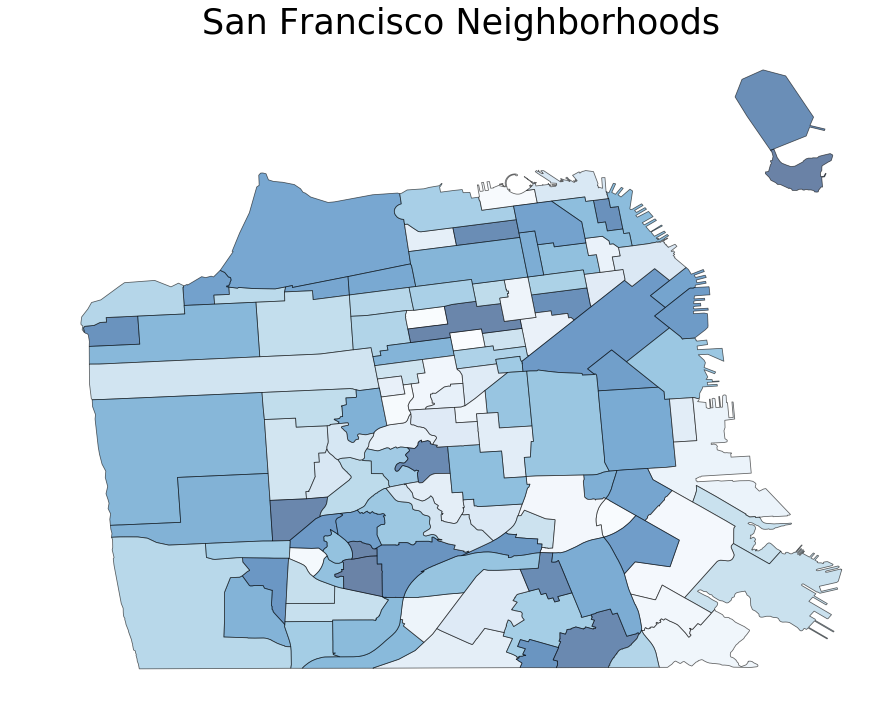

In [14]:
# Map of neighborhoods to be used in presentation slides:

fig, ax = plt.subplots(1, figsize=(15,15))
ax.axis('off')
gdf.plot(column='name', cmap='Blues', linewidth=0.8, ax=ax, alpha=0.6, edgecolor='k')
ax.set_title('San Francisco Neighborhoods', fontdict={'fontsize': '35', 'fontweight' : '3'});
plt.savefig('neighborhoods.png')

# Add Pedestrian Volume Model data:

Pull in the Pedestrian Volume Model data from the City of SF to get average pedestrian volumes per neighborhood. This CSV file is from https://data.sfgov.org/Transportation/Pedestrian-Volume-Model/awac-r27z.

In [15]:
pvm_csv = pd.read_csv('data/Pedestrian_Volume_Model.csv')

# Keeping only the interesting columns:
pvm = pvm_csv.loc[:, ['TOTEMP2', 'UNIVPROX', 'SIGNALIZED', 'PKGMETERS', 'MAXPCTSLPE', 'MODEL6_VOL', 'PCOL_RATE', 'point']]

# Converting the 'point' column to latitude and longitude:
pvm[['lat', 'lon']] = pvm['point'].str.split(", ", n=1, expand=True)

pvm['lat'] = pvm['lat'].str.strip('(').astype(float)
pvm['lon'] = pvm['lon'].str.strip(')').astype(float)

In [16]:
pvm.loc[1, 'lon'], pvm.loc[1, 'lat'] # Yep, it worked!

(-122.45190554883432, 37.710230768984616)

In [17]:
pvm['geometry'] = [Point(xy) for xy in zip(pvm['lon'], pvm['lat'])]

# Now we can make the GeoDataFrame:
gpvm = gpd.GeoDataFrame(pvm, geometry=pvm['geometry'], crs={'init': 'epsg:4326'})
gpvm = gpvm.drop(columns=['point', 'lat', 'lon'])

In [18]:
gpvm.info() # It worked!

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8135 entries, 0 to 8134
Data columns (total 8 columns):
TOTEMP2       8135 non-null int64
UNIVPROX      8135 non-null int64
SIGNALIZED    8135 non-null int64
PKGMETERS     8135 non-null int64
MAXPCTSLPE    8135 non-null int64
MODEL6_VOL    8135 non-null int64
PCOL_RATE     8135 non-null float64
geometry      8135 non-null object
dtypes: float64(1), int64(6), object(1)
memory usage: 508.5+ KB


### Spatially joining the Pedestrian Volume Model GeoDataFrame and the on-going GeoDataFrame:

In [19]:
hoods_and_peds = gpd.sjoin(gpvm, gdf2, op='within')
hoods_and_peds.info() # It worked!

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8150 entries, 0 to 8055
Data columns (total 13 columns):
TOTEMP2        8150 non-null int64
UNIVPROX       8150 non-null int64
SIGNALIZED     8150 non-null int64
PKGMETERS      8150 non-null int64
MAXPCTSLPE     8150 non-null int64
MODEL6_VOL     8150 non-null int64
PCOL_RATE      8150 non-null float64
geometry       8150 non-null object
index_right    8150 non-null int64
name           8150 non-null object
walk_score     8150 non-null float64
population     8150 non-null float64
hood_area      8150 non-null float64
dtypes: float64(4), int64(7), object(2)
memory usage: 891.4+ KB


In [20]:
annual_avg_peds = hoods_and_peds.groupby('name')['MODEL6_VOL'].mean()
annual_avg_peds.describe() # Lots of pedestrian traffic, to be expected since these are annual pedestrian counts per intersection

count    1.150000e+02
mean     1.287638e+06
std      2.422244e+06
min      8.734393e+04
25%      2.522145e+05
50%      4.301531e+05
75%      1.236867e+06
max      1.519979e+07
Name: MODEL6_VOL, dtype: float64

In [21]:
avg_employment = hoods_and_peds.groupby('name')['TOTEMP2'].mean()
avg_employment.describe() # Total employment within 1/4 mile of the data point

count      115.000000
mean      3465.447337
std       5780.590273
min        398.230769
25%        878.093926
50%       1554.333333
75%       2954.954396
max      37996.555556
Name: TOTEMP2, dtype: float64

In [22]:
pkg_meters = hoods_and_peds.groupby('name')['PKGMETERS'].mean()
pkg_meters.describe() # A binary column that I'm taking the average of, so as to calculate the
# average percentage of parking meters per intersection in a given neighborhood.

count    115.000000
mean       0.203575
std        0.221954
min        0.000000
25%        0.047065
50%        0.125000
75%        0.259985
max        0.870968
Name: PKGMETERS, dtype: float64

### Merging pedestrian, employment, and parking meter data into the main GeoDataFrame:

In [23]:
gdf2 = gdf2.merge(annual_avg_peds, on='name')
gdf2 = gdf2.merge(avg_employment, on='name')
gdf2 = gdf2.merge(pkg_meters, on='name')
gdf2.info() # It worked! New columns!

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 8 columns):
name          115 non-null object
geometry      115 non-null object
walk_score    115 non-null float64
population    115 non-null float64
hood_area     115 non-null float64
MODEL6_VOL    115 non-null float64
TOTEMP2       115 non-null float64
PKGMETERS     115 non-null float64
dtypes: float64(6), object(2)
memory usage: 8.1+ KB


In [24]:
# Bringing in the park polygons:
parks = gpd.read_file('data/Parks.geojson')
parks = parks.drop(columns=['acres', 'map_park_n', 'perimeter', 'sqft', 'gis_fd_pk', 'x', 'y'])
parks = gpd.GeoDataFrame(parks, geometry=parks['geometry'], crs={'init': 'epsg:4326'})

In [25]:
parks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 1 columns):
geometry    222 non-null object
dtypes: object(1)
memory usage: 1.8+ KB


In [26]:
hoods_and_parks = gpd.overlay(parks, gdf2, how='intersection')
hoods_and_parks = hoods_and_parks.drop(columns=['walk_score', 'population', 'MODEL6_VOL', 'TOTEMP2', 'PKGMETERS'])

I need to come back to this at another point in time. Finding the total percent of park polygons within a given neighborhood polygon is eating up too much of the time I have for this project.

# Add Street Tree Data:

Pull in the Street Tree data from the City of SF to get street tree densities per neighborhood. This CSV file is from https://data.sfgov.org/City-Infrastructure/Street-Tree-Map/337t-q2b4.

In [27]:
trees_csv = pd.read_csv('data/Street_Trees.csv')

# Keeping only the relevant location columns:
trees = trees_csv.loc[:, ['Latitude', 'Longitude']]
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191917 entries, 0 to 191916
Data columns (total 2 columns):
Latitude     189227 non-null float64
Longitude    189227 non-null float64
dtypes: float64(2)
memory usage: 2.9 MB


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
trees['geometry'] = [Point(xy) for xy in zip(trees['Longitude'], trees['Latitude'])]

# Now we can make the GeoDataFrame:
gtrees = gpd.GeoDataFrame(trees, geometry=trees['geometry'], crs={'init': 'epsg:4326'})
gtrees = gtrees.drop(columns=['Latitude', 'Longitude'])
gtrees.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 191917 entries, 0 to 191916
Data columns (total 1 columns):
geometry    191917 non-null object
dtypes: object(1)
memory usage: 1.5+ MB


In [29]:
gtrees = gtrees.dropna(axis=0)
hoods_and_trees = gpd.sjoin(gtrees, gdf2, op='within')
hoods_and_trees.info() # It worked!

/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 189115 entries, 0 to 191641
Data columns (total 9 columns):
geometry       189115 non-null object
index_right    189115 non-null int64
name           189115 non-null object
walk_score     189115 non-null float64
population     189115 non-null float64
hood_area      189115 non-null float64
MODEL6_VOL     189115 non-null float64
TOTEMP2        189115 non-null float64
PKGMETERS      189115 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 14.4+ MB


In [30]:
# Grouping neighborhoods together and counting trees in each neighborhood:
tree_count = hoods_and_trees.groupby('name')['geometry'].count()

tree_count.name = 'tree_count'
tree_count.describe()

count      114.000000
mean      1658.903509
std       1718.037164
min         30.000000
25%        699.250000
50%       1127.000000
75%       1935.250000
max      10364.000000
Name: tree_count, dtype: float64

In [31]:
gdf2 = gdf2.merge(tree_count, on='name')

# Add Business Location Data:

Pull in the Registered Business data from the City of SF to get business densities per neighborhood. This CSV file is from https://data.sfgov.org/Economy-and-Community/Registered-Business-Locations-San-Francisco/g8m3-pdis.

In [32]:
# Bringing in registered business locations:
biz_csv = pd.read_csv('data/Business_Locations_1.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
biz = biz_csv.loc[:, ['City', 'Business End Date', 'Location End Date', 'Mail City', 'Business Location']]
open_biz = biz[biz['Location End Date'].isnull()]
biz_locations = open_biz.loc[:, ['City', 'Business Location']]

biz_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129083 entries, 0 to 242551
Data columns (total 2 columns):
City                 129014 non-null object
Business Location    78262 non-null object
dtypes: object(2)
memory usage: 3.0+ MB


In [34]:
# Create a junk column, it will be dropped later
biz_locations[['junk', 'lat_lon']] = biz_locations['Business Location'].str.split("(", n=1, expand=True)

biz_locations[['lat', 'lon']] = biz_locations['lat_lon'].str.split(", ", n=1, expand=True)

biz_locations = biz_locations[pd.notnull(biz_locations['lat'])]

# Find the rows with typos and drop them, use this:
# biz_locations[biz_locations['lat'].str.contains('\n')]
biz_locations = biz_locations.drop(index=[200, 202, 657, 123684, 164804])

biz_locations['lat'] = biz_locations['lat'].astype(float)
biz_locations['lon'] = biz_locations['lon'].str.strip(')').astype(float)

In [35]:
biz_locations.loc[1, 'lon'], biz_locations.loc[1, 'lat'] # Yep, it worked!

(-122.430996, 37.799823)

In [36]:
biz_locations['geometry'] = [Point(xy) for xy in zip(biz_locations['lon'], biz_locations['lat'])]

# Now we can make the GeoDataFrame
gbiz = gpd.GeoDataFrame(biz_locations, geometry=biz_locations['geometry'], crs={'init': 'epsg:4326'})
gbiz = gbiz.drop(columns=['City', 'Business Location', 'junk', 'lat_lon', 'lat', 'lon'])
gbiz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 76609 entries, 0 to 171376
Data columns (total 1 columns):
geometry    76609 non-null object
dtypes: object(1)
memory usage: 3.7+ MB


In [37]:
# Spatial-join the business locations with gdf2:
hoods_and_biz = gpd.sjoin(gbiz, gdf2, op='within')

In [38]:
# Grouping neighborhoods together and counting businesses in each neighborhood:
biz_count = hoods_and_biz.groupby('name')['geometry'].count()

biz_count.name = 'biz_count'
biz_count.describe()

count     114.000000
mean      579.192982
std       797.918840
min        12.000000
25%       154.000000
50%       308.000000
75%       660.000000
max      4942.000000
Name: biz_count, dtype: float64

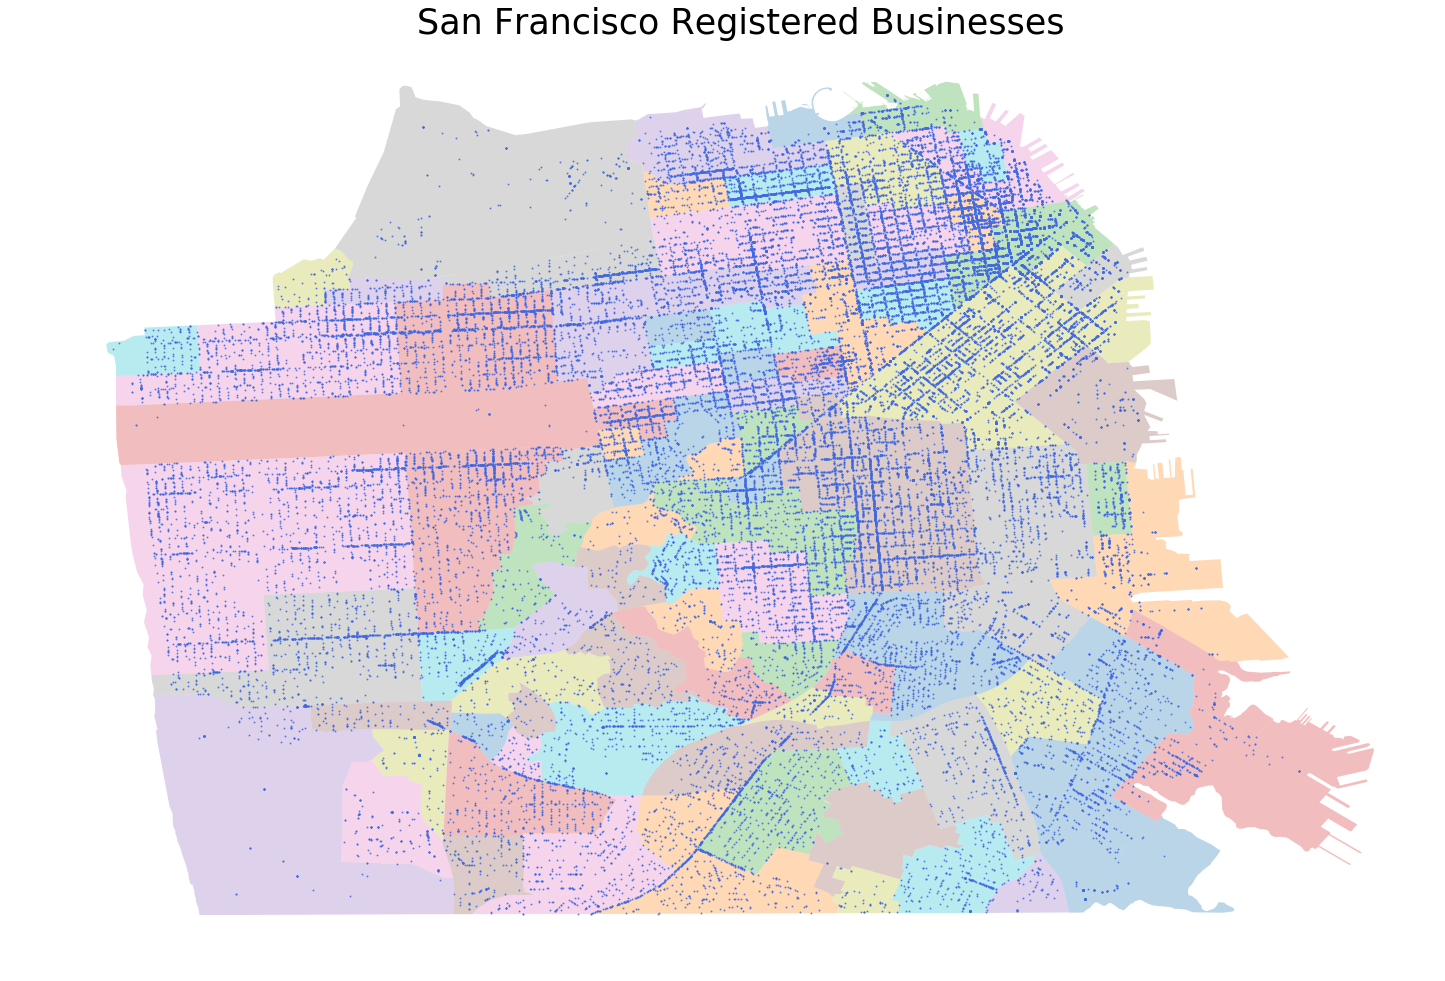

In [39]:
# Plot to use in presentation:

fig, ax = plt.subplots(1, figsize=(25,25))
ax.axis('off')
base = gdf2.plot(column='name', alpha=0.3, ax=ax)
ax.set_title('San Francisco Registered Businesses', fontdict={'fontsize': '35', 'fontweight' : '3'})
hoods_and_biz.plot(ax=base, color='royalblue', markersize=1, alpha=0.7);
plt.savefig('businesses.png')


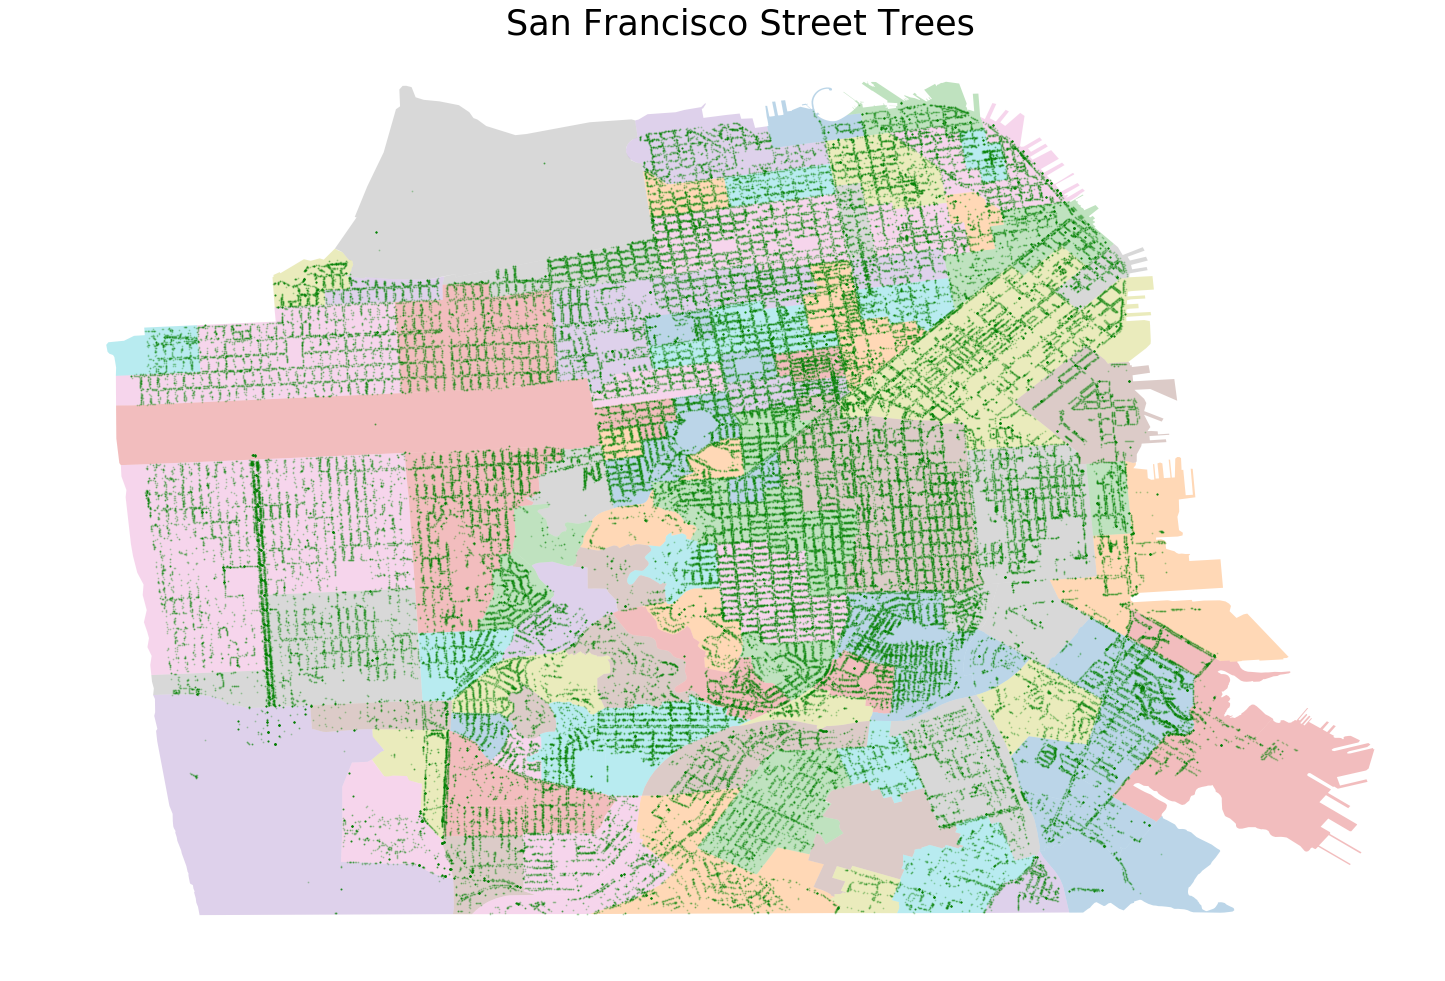

In [40]:
gdf2 = gdf2.merge(biz_count, on='name')

# Plot to use in presentation:
fig, ax = plt.subplots(1, figsize=(25, 25))
ax.axis('off')
base = gdf2.plot(column='name', alpha=0.3, ax=ax)
ax.set_title('San Francisco Street Trees', fontdict={'fontsize': '35', 'fontweight' : '3'})
hoods_and_trees.plot(ax=base, color='g', markersize=1, alpha=0.2);
plt.savefig('trees.png')


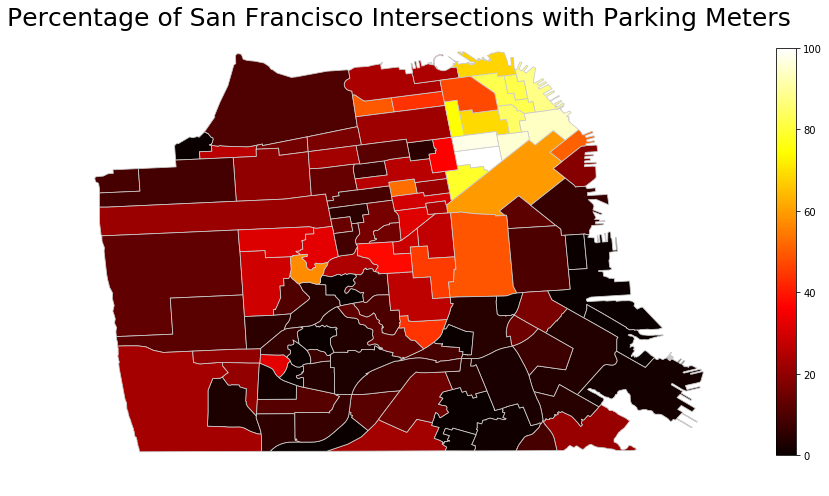

In [41]:
# Potential plot to use in presentation

norm = mpl.colors.Normalize(vmin=0,vmax=100)
sm = cm.ScalarMappable(cmap='hot', norm=norm)
sm.set_array([])
fig, ax = plt.subplots(1, figsize=(15,15))
ax.axis('off')
ax.set_title('Percentage of San Francisco Intersections with Parking Meters', fontdict={'fontsize': '25', 'fontweight' : '3'})
gdf2.plot(ax=ax, column='PKGMETERS', cmap='hot', linewidth=0.8, edgecolor='0.8')
plt.colorbar(sm, ax=ax, shrink=0.5);
plt.savefig('parkingmeters.svg')


# Looking at a pairplot for data shapes and correlations:

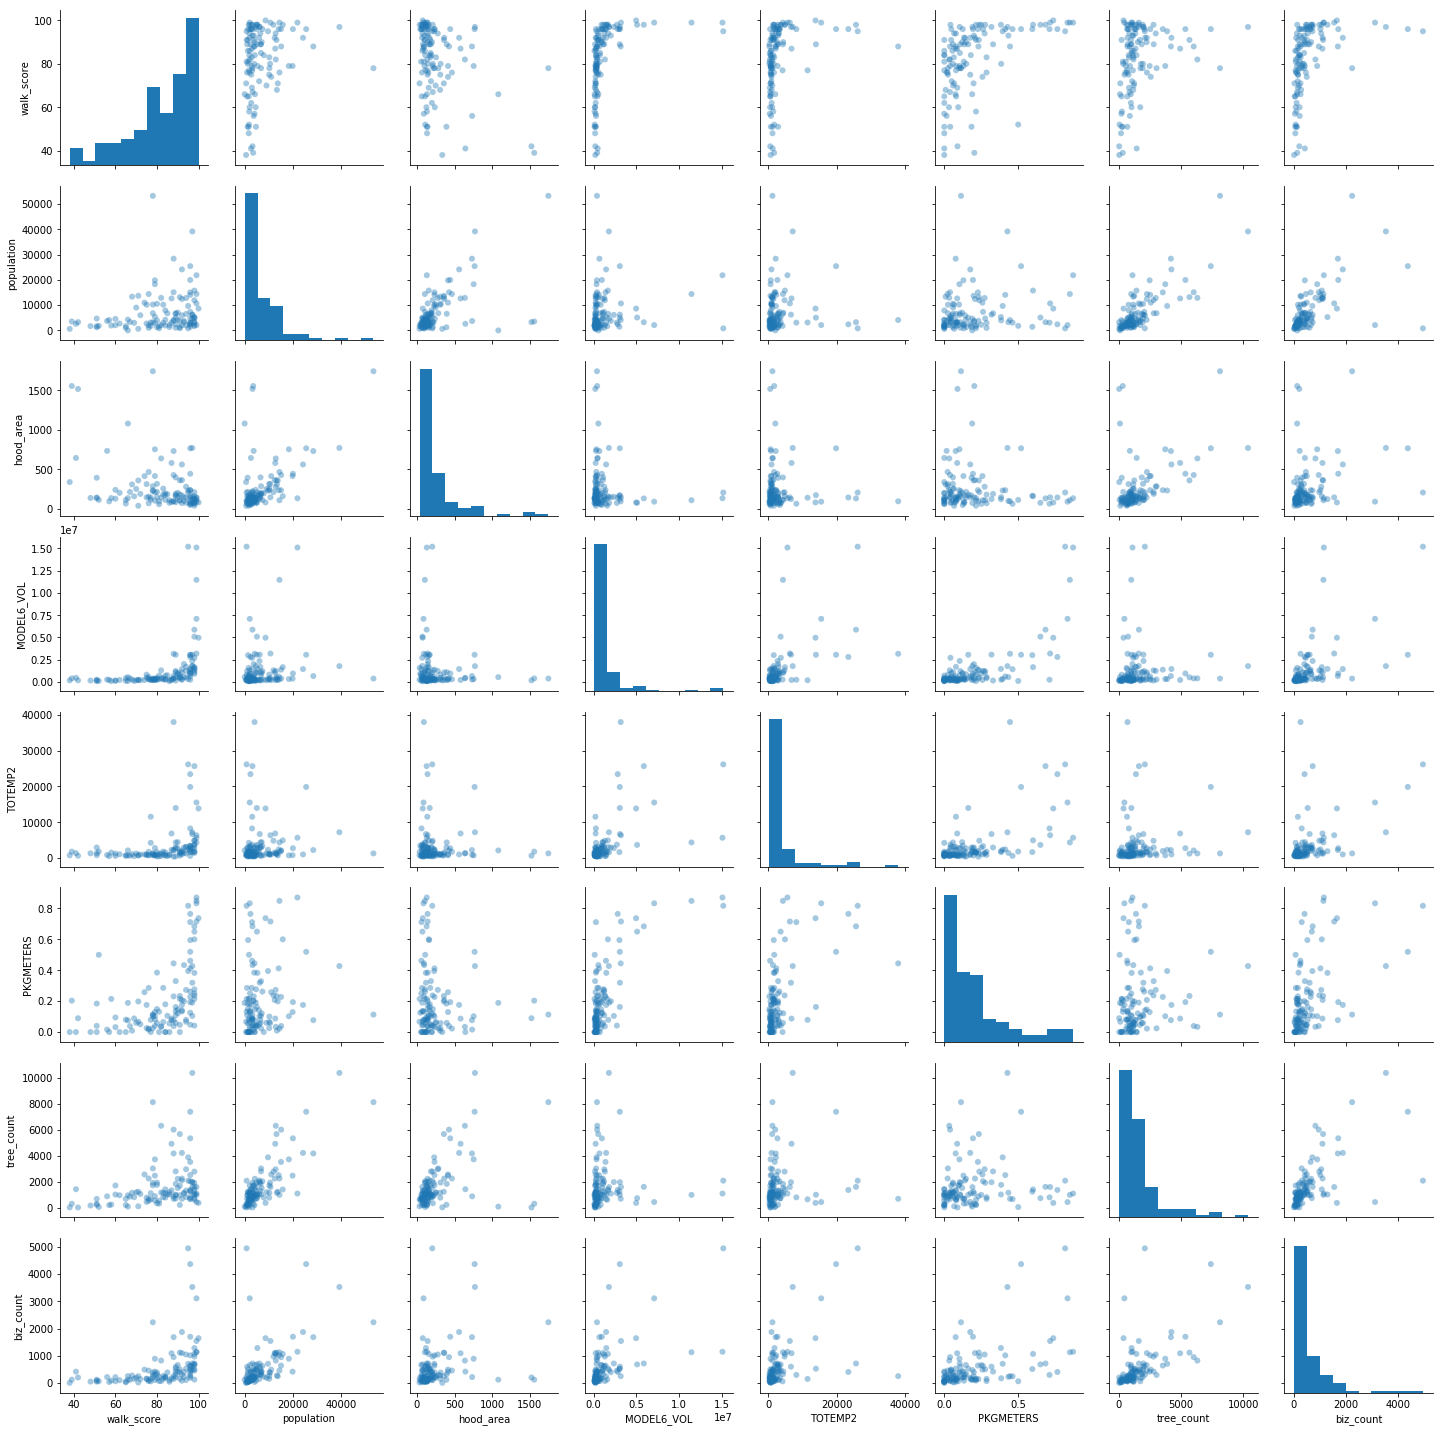

In [42]:
sns.pairplot(gdf2, plot_kws=dict(alpha=.4, edgecolor='none'));

In [43]:
# Removing Rincon Hill because of its outlier sky-high employment_density:
# (Just for the sake of modeling though. No hard feelings.)

gdf2 = gdf2.drop(index=28)

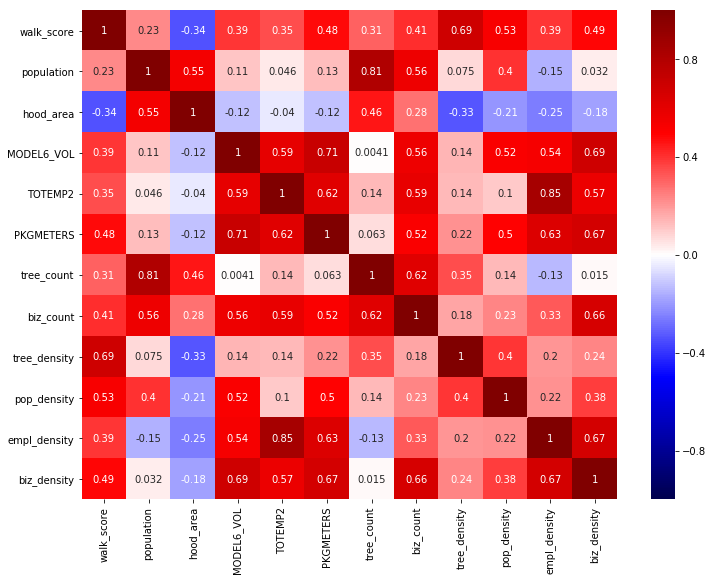

In [44]:
# Calculating various densities, in the format of count / area

gdf2['tree_density'] = gdf2['tree_count'] / gdf2['hood_area']
gdf2['pop_density'] = gdf2['population'] / gdf2['hood_area']
gdf2['empl_density'] = gdf2['TOTEMP2'] / gdf2['hood_area']
gdf2['biz_density'] = gdf2['biz_count'] / gdf2['hood_area']

# Take a peek at the correlations before attempting any feature transformations:
plt.figure(figsize=(12, 9))
sns.heatmap(data=gdf2.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


In [45]:
gdf2.head()

,name,geometry,walk_score,population,hood_area,MODEL6_VOL,TOTEMP2,PKGMETERS,tree_count,biz_count,tree_density,pop_density,empl_density,biz_density
0,Seacliff,(POLYGON ((-122.4934552679999 37.7835181710000...,77.0,1768.0,114.091657,2.719195e+05,4253.931034,0.000000,1126,68,9.869258,15.496313,37.285207,0.596012
1,Lake Street,(POLYGON ((-122.4871507149999 37.7837854270000...,88.0,3780.0,94.970056,3.784615e+05,398.230769,0.230769,874,153,9.202901,39.802019,4.193225,1.611034
2,Presidio National Park,(POLYGON ((-122.4775801709999 37.8109931130000...,42.0,3276.0,1519.457095,1.862227e+05,650.473510,0.089404,30,210,0.019744,2.156033,0.428096,0.138207
3,Presidio Terrace,(POLYGON ((-122.4724105299999 37.7873465390000...,89.0,2386.0,81.368909,4.920562e+05,457.772727,0.136364,706,224,8.676533,29.323239,5.625892,2.752894
4,Inner Richmond,(POLYGON ((-122.4726257899999 37.7863148060000...,92.0,24154.0,560.781293,1.454201e+06,1020.175573,0.175573,4219,1876,7.523432,43.072050,1.819204,3.345333


# Train-test splitting:

In [46]:
X = gdf2.drop(columns=['name', 'geometry', 'walk_score'])
y = gdf2['walk_score']
# These will be matched up later by the original index numbers, which I'm keeping
X.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 113 entries, 0 to 113
Data columns (total 11 columns):
population      113 non-null float64
hood_area       113 non-null float64
MODEL6_VOL      113 non-null float64
TOTEMP2         113 non-null float64
PKGMETERS       113 non-null float64
tree_count      113 non-null int64
biz_count       113 non-null int64
tree_density    113 non-null float64
pop_density     113 non-null float64
empl_density    113 non-null float64
biz_density     113 non-null float64
dtypes: float64(9), int64(2)
memory usage: 10.6 KB


In [47]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform an 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=10)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    val_score_2 = 1.0 - (1 - val_score) * (X_val.shape[0] - 1.) / (X_val.shape[0] - X_val.shape[1] - 1.)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('\nValidation Adj R^2 score was:', val_score_2)

    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.6f}') 
        

In [48]:
split_and_validate(X, y)
# Adjusted R^2 of 0.707 with no feature engineering! Off to a good start.


Validation R^2 score was: 0.853410404839533

Validation Adj R^2 score was: 0.706820809679066
Feature coefficient results: 

population : 0.000664
hood_area : -0.014532
MODEL6_VOL : -0.000000
TOTEMP2 : 0.000186
PKGMETERS : 15.329175
tree_count : 0.000126
biz_count : -0.000151
tree_density : 1.543565
pop_density : -0.011630
empl_density : 0.004362
biz_density : 0.545053


In [49]:
# Setting up some log-transforms here. This is out of order from the logic of my data science workflow, 
# but doing it one time here saves some headache later compared to doing it multiple times later.

X['log_tree_density'] = np.log(X.loc[:, 'tree_density']).copy()
X['log_biz_density'] = np.log(X.loc[:, 'biz_density']).copy()

In [50]:
# Setting aside 20% of data for the final test as X_test and y_test:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=5)

In [51]:
# Setting aside 25% of this new X for validation:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=9)

In [52]:
y_val.head()
# Looks good

103    96.0
78     81.0
27     96.0
85     65.0
14     98.0
Name: walk_score, dtype: float64

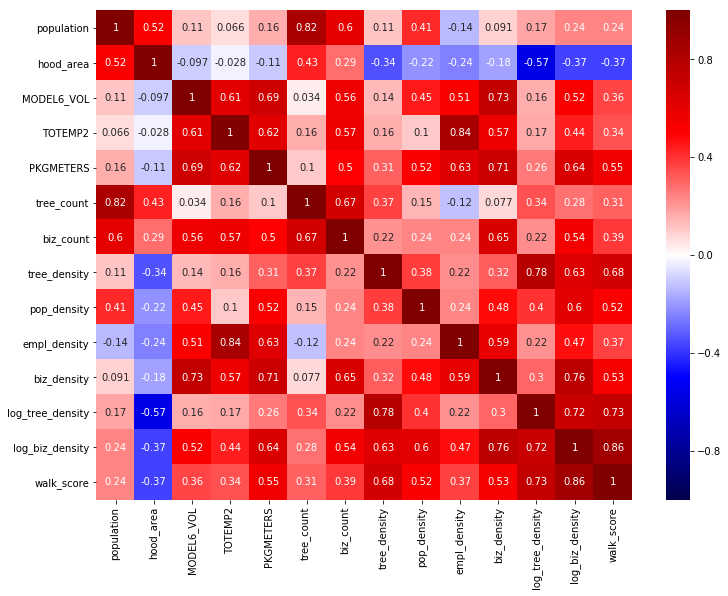

In [53]:
# The test set has already been set aside as X_test and y_test

# Re-assembling X and y for correlations, pair plots, and log-transformations:
X['walk_score'] = y

plt.figure(figsize=(12, 9))
sns.heatmap(data=X.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

# A log-transformation for walk_score is not appropriate due to the strong left-skew
# of the walk_score distribution. A log-transformation only makes it worse.

In [54]:
# Un-comment if you want to see the pair-plot, it's commented-out to save run time:

# sns.pairplot(X, plot_kws=dict(alpha=.6, edgecolor='none'));

In [55]:
# Another try at OLS, with a couple feature log-transformations and removing everything else:

# I removed these features because they had very high P-values and I noticed that when
# I did remove them, there was a negligible change in the Adj. R^2. So, by the principle of 
# Occam's Razor, I ended up with just two features!

lm2 = smf.ols('walk_score ~ log_tree_density + log_biz_density', data=X)

fit2 = lm2.fit()

fit2.summary()

# Adjusted R^2 of 0.766 and very small P-values, some progress!

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             walk_score   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     146.4
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           1.44e-28
Time:                        13:08:18   Log-Likelihood:                -308.66
No. Observations:                  90   AIC:                             623.3
Df Residuals:                      87   BIC:                             630.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           71.7499      1.686     42.545      0.000      68.398      75.102
log_tree_density     3.1151      1.015      3.069      0.003       1.098       5.132
log_biz_density      9.6008      1.010      9.508      0.000       7.594      11.608
==============================================================================
Omnibus:                       22.778   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.345
Skew:                          -0.907   Prob(JB):                     3.18e-11
Kurtosis:                       6.099   Cond. No.                         6.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

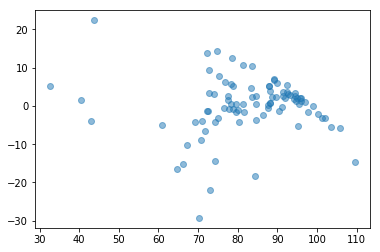

In [56]:
# plot residuals vs. fitted values
plt.figure(figsize=(6,4))
plt.scatter(fit2.predict(), fit2.resid, alpha=0.5);

# The clear negatively-sloped boundary in this plot is caused by the fact that
# the target walk_score has a maximum value of 100 (and many data points are distributed near that maximum).

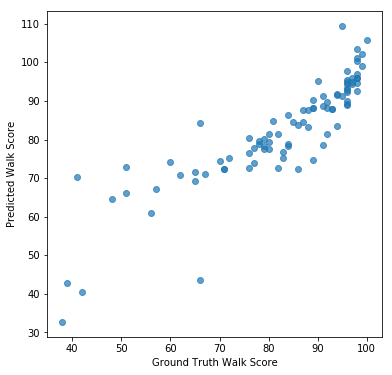

In [57]:
plt.figure(figsize=(6,6))
plt.xlabel('Ground Truth Walk Score')
plt.ylabel('Predicted Walk Score')
plt.scatter(X['walk_score'], fit2.predict(), alpha=0.7);

# Neighborhoods with very high walk scores (95+) tend to get boosted/"too-high" walk score predictions,
# so this definitely needs to be addressed in the next iteration of this project.

In [58]:
# Mean Absolute Error and Root Mean Squared Error for this model:

eval_measures.meanabs(X['walk_score'], fit2.predict()), eval_measures.rmse(X['walk_score'], fit2.predict())

# MAE of 5.08 shows that the average absolute error is 5 walk-score points.
# However, the RMSE of 7.47 walk-score-points reveals that there are some larger-error outliers.

(5.076883306143932, 7.467745250509881)

# Scaling:

In [59]:
# Scaling only the features I'm keeping: log_tree_density and log_biz_density:

X_train = X_train.loc[:, ['log_tree_density', 'log_biz_density']]
X_val = X_val.loc[:, ['log_tree_density', 'log_biz_density']]
X_test = X_test.loc[:, ['log_tree_density', 'log_biz_density']]

scaler = StandardScaler()

lm = LinearRegression()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=.1)


In [60]:
# Feature transforms for train, val, and test to run the poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()


In [61]:
# Validation

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.837
Ridge Regression val R^2: 0.837
Degree 2 polynomial regression val R^2: 0.167


Linear and Ridge Regression are in a tie at R^2 = 0.837, so we'll keep it simple and stick with Linear Regression for the final model.

In [62]:
# Looping through different alphas for Ridge and Lasso, 
# just to check the effects of different alphas:

r2_scores_ridge = {}
r2_scores_lasso = {}
for alpha in [10**i for i in range(-3, 3)]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    r2 = ridge.score(X_val, y_val)
    r2_scores_ridge[alpha] = r2
#     y_pred = ridge.predict(X_val) 

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    r2 = lasso.score(X_val, y_val)
    r2_scores_lasso[alpha] = r2
#     y_pred = lasso.predict(X_val) 


In [63]:
import pprint

pp = pprint.PrettyPrinter()
pp.pprint(r2_scores_ridge)
pp.pprint(r2_scores_lasso)

# R^2 of 0.837 is the best for both, which is no better than plain old Linear Regression. 
# I'll stick with what works.

{0.001: 0.8371380450345797,
 0.01: 0.8371196974750085,
 0.1: 0.8369357924240861,
 1: 0.8350581659511893,
 10: 0.8147007783919427,
 100: 0.6255907681359127}
{0.001: 0.8371205599059378,
 0.01: 0.8368889320770141,
 0.1: 0.8345186302918948,
 1: 0.8054132628526769,
 10: 0.34613617035504973,
 100: -0.05182657173566252}


# Drum roll, please! Running the test set:

In [64]:
# Keep only the features that were used previously:
X = X.loc[:, ['log_tree_density', 'log_biz_density']]

lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.780


It is what it is! Final R^2 of 0.780

# Re-train with all data for Final Coefficients

In [65]:

gdf2['log_tree_density'] = np.log(gdf2.loc[:, 'tree_density']).copy()
gdf2['log_biz_density'] = np.log(gdf2.loc[:, 'biz_density']).copy()

X_complete = gdf2.loc[:, ['log_tree_density', 'log_biz_density', 'walk_score']]

lm_final = smf.ols('walk_score ~ log_tree_density + log_biz_density', data=X_complete)

fit_final = lm_final.fit()
gdf2['walk_score_pred'] = fit_final.predict() 
fit_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             walk_score   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     192.6
Date:                Sun, 21 Jul 2019   Prob (F-statistic):           1.17e-36
Time:                        13:08:19   Log-Likelihood:                -384.78
No. Observations:                 113   AIC:                             775.6
Df Residuals:                     110   BIC:                             783.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           69.7375      1.471     47.424      0.000      66.823      72.652
log_tree_density     4.0556      0.890      4.555      0.000       2.291       5.820
log_biz_density      9.0250      0.867     10.414      0.000       7.308      10.742
==============================================================================
Omnibus:                       19.424   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.544
Skew:                          -0.635   Prob(JB):                     3.50e-10
Kurtosis:                       5.763   Cond. No.                         6.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Coefficient and Intercept Interpretation:

For every "e"-fold increase (or 2.7-fold increase) in street tree density in a given neighborhood, the walk score of that neighborhood will increase by 4.06 points.

Likewise, for every "e"-fold increase (or 2.7-fold increase) in business density in a given neighborhood, the walk score of that neighborhood will increase by 9.03 points.

The intercept means that a neighborhood with one street tree per acre (the intercept where e^0 = 1) and one business per acre (the intercept where e^0 = 1) would have a walk score of 69.74.

# Final choropleths of Predicted Walk Score and Ground Truth Walk Score:

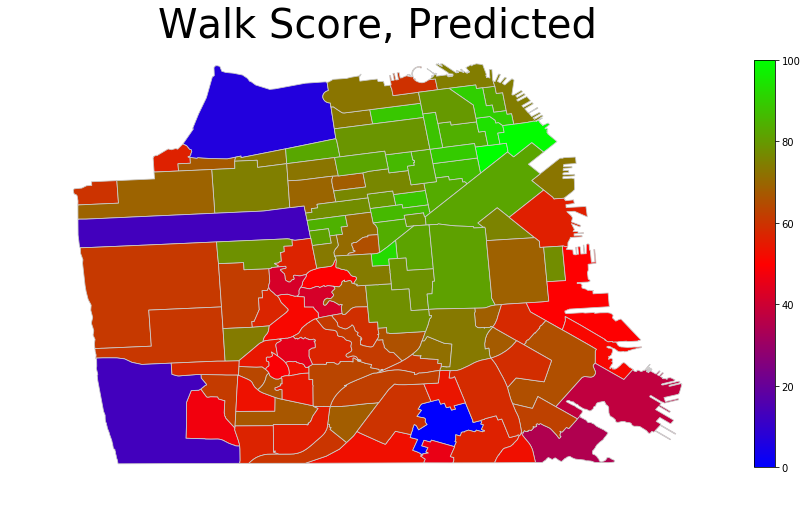

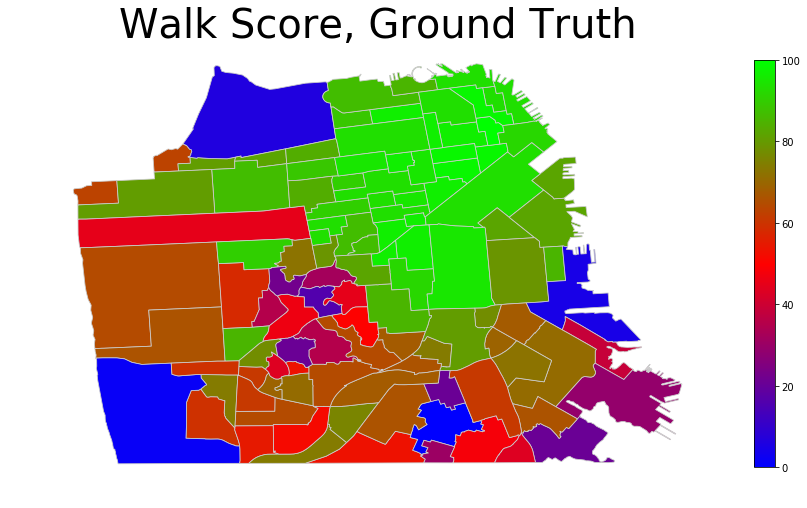

In [66]:
norm = mpl.colors.Normalize(vmin=0,vmax=100)
sm = cm.ScalarMappable(cmap='brg', norm=norm)
sm.set_array([])
fig, ax = plt.subplots(1, figsize=(15,15))
ax.axis('off')
ax.set_title('Walk Score, Predicted', fontdict={'fontsize': '40', 'fontweight' : '3'})
gdf2.plot(ax=ax, column='walk_score_pred', cmap='brg', linewidth=0.8, edgecolor='0.8')
plt.colorbar(sm, ax=ax, shrink=0.5)
plt.savefig('walk_score_predicted.png')

fig, ax = plt.subplots(1, figsize=(15,15))
ax.axis('off')
ax.set_title('Walk Score, Ground Truth', fontdict={'fontsize': '40', 'fontweight' : '3'})
gdf2.plot(ax=ax, column='walk_score', cmap='brg', linewidth=0.8, edgecolor='0.8')
plt.colorbar(sm, ax=ax, shrink=0.5);
plt.savefig('walk_score_true.png')